In [ ]:
!nvidia-smi

Fri May 12 03:48:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    46W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q diffusers==0.14.0 transformers xformers git+https://github.com/huggingface/accelerate.git
!pip install -q opencv-contrib-python
!pip install -q controlnet_aux
!pip install -q --upgrade transformers diffusers ftfy huggingface_hub
!pip install -q accelerate 
!pip install -q einops
!pip install -q gradio
!pip install -q open_clip_torch
!pip install -q --upgrade omegaconf
!pip install -q pytorch-lightning

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 92.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.2/108.2 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.0 MB/s eta 0:00:00


In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import OneCycleLR
import os
from PIL import Image
import numpy as np
import albumentations as A
import albumentations.pytorch as AP
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

from base64 import b64encode
import numpy
import json
import cv2
# from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
import subprocess

# For video display:
from IPython.display import HTML
from pathlib import Path
from torch import autocast
from torchvision import transforms as tfms
import pytorch_lightning as pl
from transformers import logging #CLIPTextModel, CLIPTokenizer, 

# torch.manual_seed(1)

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

from huggingface_hub import hf_hub_download
from diffusers import DiffusionPipeline
from huggingface_hub import notebook_login

In [ ]:
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
# Copying the code from github to colab
os.chdir('/content/')
!git clone https://github.com/anilbhatt1/ControlNet.git 
%cd '/content/ControlNet'
! ls

Cloning into 'ControlNet'...
remote: Enumerating objects: 1398, done.
remote: Counting objects: 100% (477/477), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 1398 (delta 419), reused 411 (delta 392), pack-reused 921
Receiving objects: 100% (1398/1398), 122.40 MiB | 57.02 MiB/s, done.
Resolving deltas: 100% (636/636), done.
/content/ControlNet
annotator			      gradio_scribble2image.py
cldm				      gradio_seg2image.py
config.py			      ldm
docs				      LICENSE
environment.yaml		      models
font				      README.md
github_page			      share.py
gradio_annotator.py		      test_imgs
gradio_canny2image.py		      tool_add_control.py
gradio_depth2image.py		      tool_add_control_sd21.py
gradio_fake_scribble2image.py	      tool_transfer_control.py
gradio_hed2image.py		      tutorial_dataset.py
gradio_hough2image.py		      tutorial_dataset_test.py
gradio_normal2image.py		      tutorial_train.py
gradio_pose2image.py		      tutorial_train_sd21.py
gradio_scribble2image_inte

In [ ]:
os.chdir('/content/ControlNet')

In [ ]:
from share import *
import config

import einops
import gradio as gr
import random


from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from annotator.canny import CannyDetector
from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler

In [ ]:
downloaded_model_path = hf_hub_download(repo_id="runwayml/stable-diffusion-v1-5",
                                        filename="v1-5-pruned.ckpt",
                                        use_auth_token=True)
print(downloaded_model_path)

In [ ]:
!mkdir '/content/models'

In [ ]:
!cp '/root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/aa9ba505e1973ae5cd05f5aedd345178f52f8e6a/v1-5-pruned.ckpt' '/content/models'

In [ ]:
os.chdir('/content/ControlNet')

In [ ]:
import share
import cldm

input_path = f'/content/models/v1-5-pruned.ckpt'
output_path = f'/content/models/control_sd15_ini.ckpt'

In [ ]:
resume_path = '/content/gdrive/MyDrive/EVA8_S15_May11/epoch=9-step=9470.ckpt'

In [ ]:
apply_canny = CannyDetector()

model = create_model('./models/cldm_v15.yaml').cpu()
#model.load_state_dict(load_state_dict('/content/models/control_sd15_canny.pth', location='cuda'))
model.load_state_dict(load_state_dict('/content/gdrive/MyDrive/EVA8_S15_May11/epoch=9-step=9470.ckpt', location='cuda'))
model = model.cuda()
ddim_sampler = DDIMSampler(model)

create_model-config : {'model': {'target': 'cldm.cldm.ControlLDM', 'params': {'linear_start': 0.00085, 'linear_end': 0.012, 'num_timesteps_cond': 1, 'log_every_t': 200, 'timesteps': 1000, 'first_stage_key': 'jpg', 'cond_stage_key': 'txt', 'control_key': 'hint', 'image_size': 64, 'channels': 4, 'cond_stage_trainable': False, 'conditioning_key': 'crossattn', 'monitor': 'val/loss_simple_ema', 'scale_factor': 0.18215, 'use_ema': False, 'only_mid_control': False, 'control_stage_config': {'target': 'cldm.cldm.ControlNet', 'params': {'image_size': 32, 'in_channels': 4, 'hint_channels': 3, 'model_channels': 320, 'attention_resolutions': [4, 2, 1], 'num_res_blocks': 2, 'channel_mult': [1, 2, 4, 4], 'num_heads': 8, 'use_spatial_transformer': True, 'transformer_depth': 1, 'context_dim': 768, 'use_checkpoint': True, 'legacy': False}}, 'unet_config': {'target': 'cldm.cldm.ControlledUnetModel', 'params': {'image_size': 32, 'in_channels': 4, 'out_channels': 4, 'model_channels': 320, 'attention_resolu

Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is 768 and using 8 heads.
Setting up Me

In [ ]:
def process(input_image, prompt, a_prompt, n_prompt, num_samples, image_resolution, ddim_steps, guess_mode, strength, scale, seed, eta, low_threshold, high_threshold):
    with torch.no_grad():
        img = resize_image(HWC3(input_image), image_resolution)
        H, W, C = img.shape

        detected_map = apply_canny(img, low_threshold, high_threshold)
        detected_map = HWC3(detected_map)

        control = torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
        control = torch.stack([control for _ in range(num_samples)], dim=0)
        control = einops.rearrange(control, 'b h w c -> b c h w').clone()

        if seed == -1:
            seed = random.randint(0, 65535)
        seed_everything(seed)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)]}
        un_cond = {"c_concat": None if guess_mode else [control], "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)]}
        shape = (4, H // 8, W // 8)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=True)

        model.control_scales = [strength * (0.825 ** float(12 - i)) for i in range(13)] if guess_mode else ([strength] * 13)  # Magic number. IDK why. Perhaps because 0.825**12<0.01 but 0.826**12>0.01
        samples, intermediates = ddim_sampler.sample(ddim_steps, num_samples,
                                                     shape, cond, verbose=False, eta=eta,
                                                     unconditional_guidance_scale=scale,
                                                     unconditional_conditioning=un_cond)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        x_samples = model.decode_first_stage(samples)
        x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

        results = [x_samples[i] for i in range(num_samples)]
    return [255 - detected_map] + results


In [ ]:
block = gr.Blocks().queue()
with block:
    with gr.Row():
        gr.Markdown("## Control Stable Diffusion with Canny Edge Maps")
    with gr.Row():
        with gr.Column():
            input_image = gr.Image(source='upload', type="numpy")
            prompt = gr.Textbox(label="Prompt")
            run_button = gr.Button(label="Run")
            with gr.Accordion("Advanced options", open=False):
                num_samples = gr.Slider(label="Images", minimum=1, maximum=12, value=1, step=1)
                image_resolution = gr.Slider(label="Image Resolution", minimum=256, maximum=768, value=512, step=64)
                strength = gr.Slider(label="Control Strength", minimum=0.0, maximum=2.0, value=1.0, step=0.01)
                guess_mode = gr.Checkbox(label='Guess Mode', value=False)
                low_threshold = gr.Slider(label="Canny low threshold", minimum=1, maximum=255, value=100, step=1)
                high_threshold = gr.Slider(label="Canny high threshold", minimum=1, maximum=255, value=200, step=1)
                ddim_steps = gr.Slider(label="Steps", minimum=1, maximum=100, value=20, step=1)
                scale = gr.Slider(label="Guidance Scale", minimum=0.1, maximum=30.0, value=9.0, step=0.1)
                seed = gr.Slider(label="Seed", minimum=-1, maximum=2147483647, step=1, randomize=True)
                eta = gr.Number(label="eta (DDIM)", value=0.0)
                a_prompt = gr.Textbox(label="Added Prompt", value='best quality, extremely detailed')
                n_prompt = gr.Textbox(label="Negative Prompt",
                                      value='longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality')
        with gr.Column():
            result_gallery = gr.Gallery(label='Output', show_label=False, elem_id="gallery").style(grid=2, height='auto')
    ips = [input_image, prompt, a_prompt, n_prompt, num_samples, image_resolution, ddim_steps, guess_mode, strength, scale, seed, eta, low_threshold, high_threshold]
    run_button.click(fn=process, inputs=ips, outputs=[result_gallery])


block.launch(server_name='0.0.0.0')

/usr/local/lib/python3.10/dist-packages/gradio/components.py:4431: UserWarning: The 'grid' parameter will be deprecated. Please use 'columns' instead.
  warnings.warn(


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://82db44ba9843db9864.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


###Inference using from_pretrained (Need to figure out a way to pass .ckpt files)

In [ ]:
from diffusers import StableDiffusionControlNetPipeline
import cv2
from PIL import Image
import numpy as np

In [ ]:
img_path = f'/content/img00016.jpg'
raw_image = Image.open(img_path)

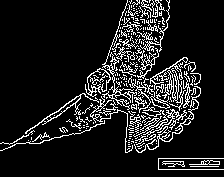

In [ ]:
image = np.array(raw_image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
canny_image

In [ ]:
resume_path = '/content/gdrive/MyDrive/EVA8_S15_May11/epoch=9-step=9470.ckpt'

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch

# controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
controlnet = ControlNetModel.from_pretrained(resume_path, torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)

In [ ]:
from diffusers import UniPCMultistepScheduler

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

In [ ]:
pipe.enable_model_cpu_offload()

In [ ]:
pipe.enable_xformers_memory_efficient_attention()

In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

prompt = ", best quality, extremely detailed"
# prompt = [t + prompt for t in [" Drone", "Kim Kardashian", "rihanna", "taylor swift"]]
prompt = [t + prompt for t in [" Winged Drone"]]
generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(len(prompt))]

output = pipe(
    prompt,
    canny_image,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * len(prompt),
    generator=generator,
    num_inference_steps=20,
)

image_grid(output.images, 2, 2)